In [3]:
# import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import re
#import random
#from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import QuantileTransformer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
#from string import ascii_letters
import seaborn as sns
import h5py as h5

#from string import ascii_letters

In [2]:
df =pd.read_pickle('../pickle_pd/pd_top_25.pkl')
features = ['lep_pt_2','lep_pt_1','jet_n','lep_E_1','jet_pt_0','lep_eta_0','jet_pt_1','lep_pt_0','lep_E_2','lep_eta_1','lep_phi_1','lep_phi_0',
            'lep_ptcone30_1','lep_ptcone30_0','jet_eta_0','jet_m','lep_E_0','jet_eta_1','jet_pt_2','lep_pt_3','jet_E_0','lep_charge_1','lep_charge_0','lep_E_3']

In [17]:
qt = QuantileTransformer(random_state=0)

In [18]:
df[features] = qt.fit_transform(df[features])

In [20]:
df.head()

,lep_pt_2,met_et,lep_pt_1,jet_n,lep_E_1,jet_pt_0,lep_eta_0,jet_pt_1,lep_pt_0,lep_E_2,...,jet_m,lep_E_0,jet_eta_1,jet_pt_2,lep_pt_3,jet_E_0,lep_charge_1,lep_charge_0,lep_E_3,label
0,0.827001,34466.183594,0.875564,0.000000,0.684914,0.000000,0.299827,0.0,0.681784,0.810798,...,0.087922,0.455597,0.502002,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0
1,0.000000,13054.372070,0.825440,0.000000,0.637056,0.000000,0.640679,0.0,0.553083,0.000000,...,0.087922,0.294708,0.502002,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0
2,0.889617,14494.322266,0.942505,0.426927,0.821263,0.336390,0.917692,0.0,0.463449,0.916962,...,0.127201,0.732639,0.502002,0.0,0.957501,0.419380,0.000000,1.0,0.939566,0
3,0.959473,16763.203125,0.741359,0.000000,0.901442,0.000000,0.496579,0.0,0.066080,0.928813,...,0.127201,0.010249,0.502002,0.0,0.976511,0.000000,1.000000,0.0,0.955656,0
4,0.000000,78260.984375,0.000000,0.426927,0.000000,0.904151,0.497492,0.0,0.801852,0.000000,...,0.905050,0.473166,0.502002,0.0,0.000000,0.783754,0.499499,1.0,0.000000,0


In [15]:
df['lep_pt_2'].values

array([ 8604.808,     0.   , 14819.154, ...,     0.   ,     0.   ,
           0.   ], dtype=float32)

In [21]:
 X_train, X_test, y_train, y_test = train_test_split( df[features], df['label'], test_size=0.4, random_state=42,shuffle = True)
 X_test, X_val, y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42,shuffle = True)

In [22]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [23]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, #eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [25]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

  0%|                              | 0/20 [00:00<?, ?trial/s, best loss=?]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7749205404211598                                                        
  5%|▏  | 1/20 [00:12<03:52, 12.22s/trial, best loss: -0.7749205404211598]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.77713868697247                                                          
 10%|▌    | 2/20 [00:28<04:22, 14.57s/trial, best loss: -0.77713868697247]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7768026041616655                                                        
 15%|▊    | 3/20 [00:43<04:12, 14.88s/trial, best loss: -0.77713868697247]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7751509972057115                                                        
 20%|█    | 4/20 [00:56<03:47, 14.20s/trial, best loss: -0.77713868697247]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7770906751423551                                                        
 25%|█▎   | 5/20 [01:10<03:30, 14.03s/trial, best loss: -0.77713868697247]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7753430445261712                                                        
 30%|█▌   | 6/20 [01:24<03:13, 13.83s/trial, best loss: -0.77713868697247]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7753142374281022                                                        
 35%|█▊   | 7/20 [01:37<02:56, 13.59s/trial, best loss: -0.77713868697247]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7773499390249757                                                        
 40%|█▏ | 8/20 [01:52<02:49, 14.16s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7769754467500792                                                        
 45%|█▎ | 9/20 [02:08<02:41, 14.66s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7759191864875505                                                        
 50%|█ | 10/20 [02:22<02:25, 14.54s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7765625450110908                                                        
 55%|█ | 11/20 [02:37<02:11, 14.66s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7754390681864012                                                        
 60%|█▏| 12/20 [02:51<01:54, 14.37s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7770042538481482                                                        
 65%|█▎| 13/20 [03:09<01:48, 15.51s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7764569189848378                                                        
 70%|█▍| 14/20 [03:23<01:31, 15.20s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7751125877416195                                                        
 75%|█▌| 15/20 [03:37<01:13, 14.70s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7754390681864012                                                        
 80%|█▌| 16/20 [03:50<00:57, 14.29s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7770330609462172                                                        
 85%|█▋| 17/20 [04:05<00:43, 14.49s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.777148289338493                                                         
 90%|█▊| 18/20 [04:21<00:29, 14.96s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7757943557292517                                                        
 95%|█▉| 19/20 [04:34<00:14, 14.47s/trial, best loss: -0.7773499390249757]

/Users/ndueser/Documents/Niklas/ML_Seminar/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                    
0.7758423675593666                                                        
100%|██| 20/20 [04:49<00:00, 14.46s/trial, best loss: -0.7773499390249757]


In [86]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.7749205404211598, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bytree': [0],
    'gamma': [0],
    'max_depth': [0],
    'min_child_weight': [0],
    'reg_alpha': [0],
    'reg_lambda': [0]},
   'vals': {'colsample_bytree': [0.7737467747970292],
    'gamma': [8.259789337581461],
    'max_depth': [5.0],
    'min_child_weight': [2.0],
    'reg_alpha': [179.0],
    'reg_lambda': [0.8077851456193298]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2023, 7, 20, 17, 4, 38, 920000),
  'refresh_time': datetime.datetime(2023, 7, 20, 17, 4, 51, 141000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.77713868697247, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bytree': [1],
    'gamma': [1],
    'max

In [132]:
trial_res = pd.DataFrame()
for keys in trials.trials[0]['misc']['vals'].keys():
    trial_res[keys] = pd.Series([trial['misc']['vals'][keys] for trial in trials.trials])
trial_res = trial_res.apply(pd.Series.squeeze)
trial_res['loss'] = [trial['result']['loss'] for trial in trials.trials]
col_names = list(trial_res)
trial_res = pd.concat((pd.DataFrame(trial_res[col].tolist()) for col in list(trial_res)), axis=1)
trial_res.columns = col_names

In [133]:
trial_res

,colsample_bytree,gamma,max_depth,min_child_weight,reg_alpha,reg_lambda,loss
0,0.773747,8.259789,5.0,2.0,179.0,0.807785,-0.774921
1,0.998427,1.607114,15.0,1.0,53.0,0.133316,-0.777139
2,0.908593,5.981465,15.0,4.0,67.0,0.296155,-0.776803
3,0.566373,5.663690,6.0,2.0,150.0,0.155327,-0.775151
4,0.894578,1.492790,5.0,8.0,87.0,0.926022,-0.777091
5,0.818558,4.181084,7.0,2.0,152.0,0.605153,-0.775343
6,0.751071,1.436919,5.0,0.0,160.0,0.991208,-0.775314
7,0.887327,1.041870,16.0,5.0,78.0,0.917253,-0.777350
8,0.762112,3.355814,17.0,9.0,69.0,0.276874,-0.776975
9,0.589792,7.595207,6.0,4.0,104.0,0.289549,-0.775919


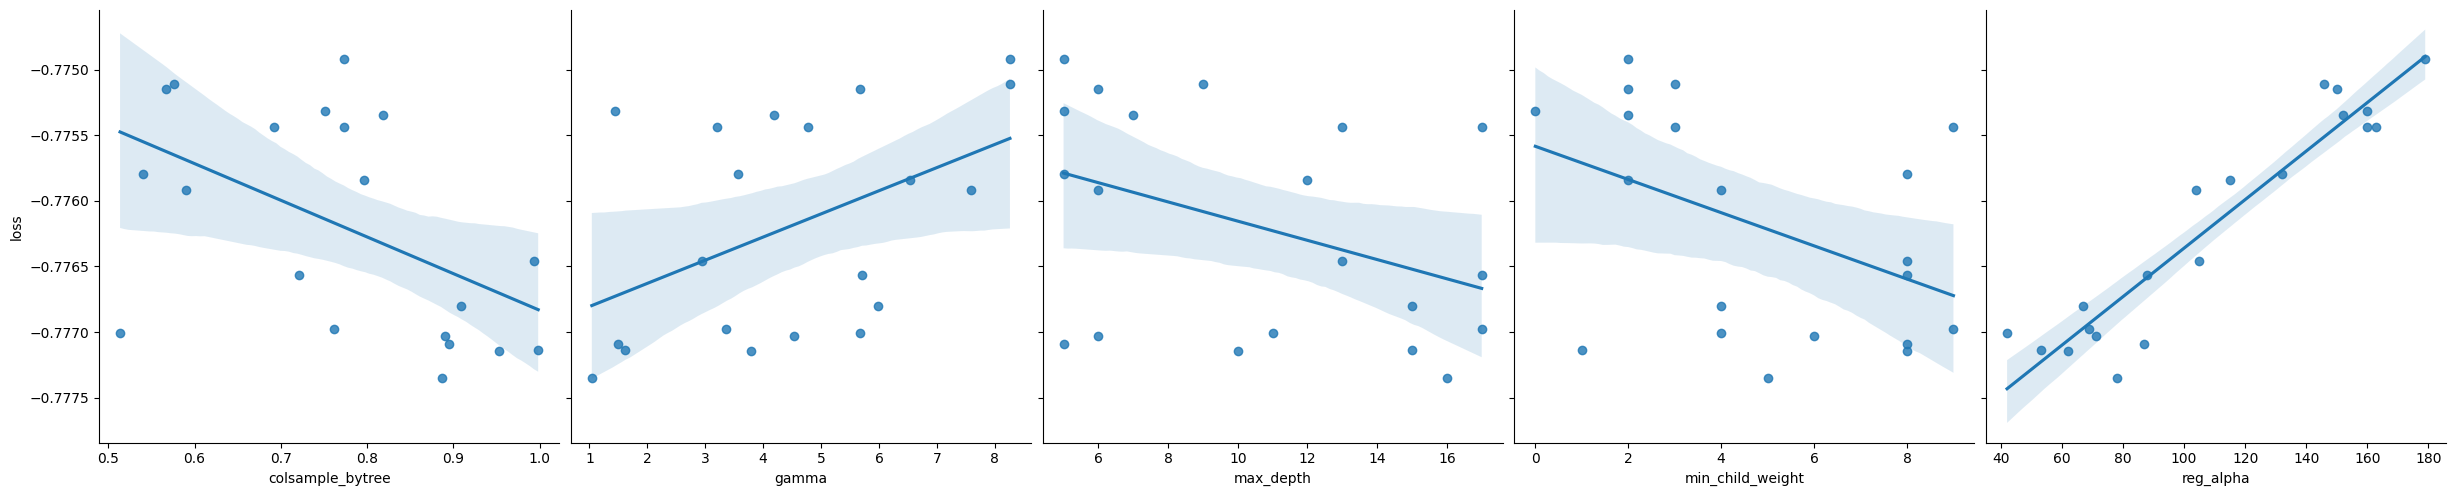

In [134]:
sns.pairplot(trial_res, x_vars=[ 'colsample_bytree', 'gamma', 'max_depth', 'min_child_weight', 'reg_alpha', ], y_vars=['loss'], kind='reg',  height=5)

In [128]:
trial_res


,colsample_bytree,gamma,max_depth,min_child_weight,reg_alpha,reg_lambda,loss
0,[0.7737467747970292],[8.259789337581461],[5.0],[2.0],[179.0],[0.8077851456193298],-0.774921
1,[0.9984274842528611],[1.607113795991335],[15.0],[1.0],[53.0],[0.13331561766864464],-0.777139
2,[0.9085926772884718],[5.981464714094457],[15.0],[4.0],[67.0],[0.2961551379980526],-0.776803
3,[0.5663728195394431],[5.663689846211034],[6.0],[2.0],[150.0],[0.15532691959599132],-0.775151
4,[0.8945782390463473],[1.4927902718670154],[5.0],[8.0],[87.0],[0.9260217690039079],-0.777091
5,[0.818557611176431],[4.181083621495743],[7.0],[2.0],[152.0],[0.6051531207041821],-0.775343
6,[0.7510709234943113],[1.4369190416639066],[5.0],[0.0],[160.0],[0.9912080945012863],-0.775314
7,[0.887326669361786],[1.041870432000822],[16.0],[5.0],[78.0],[0.9172526779898644],-0.777350
8,[0.7621115331038684],[3.3558138856552677],[17.0],[9.0],[69.0],[0.276873951669948],-0.776975
9,[0.5897915095380143],[7.595206660884447],[6.0],[4.0],[104.0],[0.2895488597929461],-0.775919


In [131]:
pd.concat((pd.DataFrame(trial_res[col].tolist()) for col in list(trial_res)), axis=1)

,0,0,0,0,0,0,0
0,0.773747,8.259789,5.0,2.0,179.0,0.807785,-0.774921
1,0.998427,1.607114,15.0,1.0,53.0,0.133316,-0.777139
2,0.908593,5.981465,15.0,4.0,67.0,0.296155,-0.776803
3,0.566373,5.663690,6.0,2.0,150.0,0.155327,-0.775151
4,0.894578,1.492790,5.0,8.0,87.0,0.926022,-0.777091
5,0.818558,4.181084,7.0,2.0,152.0,0.605153,-0.775343
6,0.751071,1.436919,5.0,0.0,160.0,0.991208,-0.775314
7,0.887327,1.041870,16.0,5.0,78.0,0.917253,-0.777350
8,0.762112,3.355814,17.0,9.0,69.0,0.276874,-0.776975
9,0.589792,7.595207,6.0,4.0,104.0,0.289549,-0.775919


In [121]:
trial_res

colsample_bytree                                             0.773747
gamma                                                        8.259789
max_depth                                                         5.0
min_child_weight                                                  2.0
reg_alpha                                                       179.0
reg_lambda                                                   0.807785
loss                [-0.7749205404211598, -0.77713868697247, -0.77...
dtype: object

In [69]:
pd.DataFrame.from_dict(trials.trials[1]['misc']['vals'])

,colsample_bytree,gamma,max_depth,min_child_weight,reg_alpha,reg_lambda
0,0.998427,1.607114,15.0,1.0,53.0,0.133316


In [13]:
best_hyperparams

{'colsample_bytree': 0.7576375295176072,
 'gamma': 1.9649156900065439,
 'max_depth': 3.0,
 'min_child_weight': 7.0,
 'reg_alpha': 42.0,
 'reg_lambda': 0.42853588282269506}

In [14]:
xgb_model=xgb.XGBClassifier(
                    n_estimators =180, max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                    reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                    colsample_bytree=int(best_hyperparams['colsample_bytree']))         
xgb_model.fit(X_train[features],y_train,
             eval_set = [( X_train, y_train), ( X_test, y_test)])
#y_pred = xgb_model.predict(X_val[features])

[0]	validation_0-mlogloss:1.03990	validation_1-mlogloss:1.04026
[1]	validation_0-mlogloss:1.00416	validation_1-mlogloss:1.00492
[2]	validation_0-mlogloss:0.99056	validation_1-mlogloss:0.99132
[3]	validation_0-mlogloss:0.98072	validation_1-mlogloss:0.98177
[4]	validation_0-mlogloss:0.96831	validation_1-mlogloss:0.96931
[5]	validation_0-mlogloss:0.94244	validation_1-mlogloss:0.94277
[6]	validation_0-mlogloss:0.92796	validation_1-mlogloss:0.92854
[7]	validation_0-mlogloss:0.88775	validation_1-mlogloss:0.88852
[8]	validation_0-mlogloss:0.85968	validation_1-mlogloss:0.86060
[9]	validation_0-mlogloss:0.82873	validation_1-mlogloss:0.82965
[10]	validation_0-mlogloss:0.80931	validation_1-mlogloss:0.81029
[11]	validation_0-mlogloss:0.78940	validation_1-mlogloss:0.79040
[12]	validation_0-mlogloss:0.78116	validation_1-mlogloss:0.78187
[13]	validation_0-mlogloss:0.76953	validation_1-mlogloss:0.77010
[14]	validation_0-mlogloss:0.73310	validation_1-mlogloss:0.73307
[15]	validation_0-mlogloss:0.73049	

[126]	validation_0-mlogloss:0.51261	validation_1-mlogloss:0.51061
[127]	validation_0-mlogloss:0.51249	validation_1-mlogloss:0.51047
[128]	validation_0-mlogloss:0.51240	validation_1-mlogloss:0.51041
[129]	validation_0-mlogloss:0.51214	validation_1-mlogloss:0.51016
[130]	validation_0-mlogloss:0.51213	validation_1-mlogloss:0.51016
[131]	validation_0-mlogloss:0.51154	validation_1-mlogloss:0.50955
[132]	validation_0-mlogloss:0.51142	validation_1-mlogloss:0.50944
[133]	validation_0-mlogloss:0.51128	validation_1-mlogloss:0.50930
[134]	validation_0-mlogloss:0.51116	validation_1-mlogloss:0.50919
[135]	validation_0-mlogloss:0.51110	validation_1-mlogloss:0.50915
[136]	validation_0-mlogloss:0.51088	validation_1-mlogloss:0.50895
[137]	validation_0-mlogloss:0.51042	validation_1-mlogloss:0.50853
[138]	validation_0-mlogloss:0.51013	validation_1-mlogloss:0.50821
[139]	validation_0-mlogloss:0.51007	validation_1-mlogloss:0.50815
[140]	validation_0-mlogloss:0.50969	validation_1-mlogloss:0.50779
[141]	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.9649156900065439,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

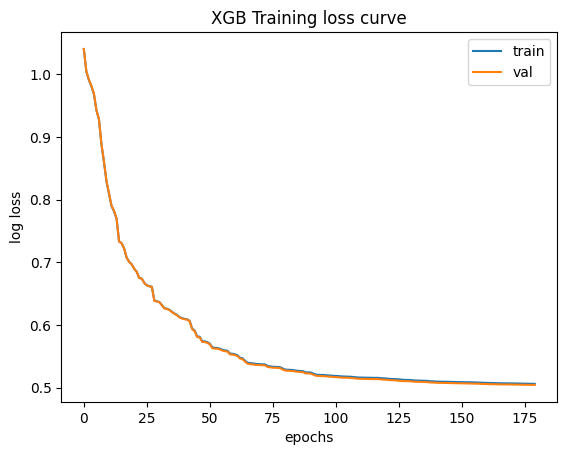

In [16]:
history  = xgb_model.evals_result()
plt.plot(history['validation_0']['mlogloss'], label='train')
plt.plot(history['validation_1']['mlogloss'], label='val')
plt.ylabel('log loss')
plt.xlabel('epochs')
plt.title('XGB Training loss curve')
plt.legend()

In [33]:
history  = xgb_model.evals_result()

In [37]:
history.keys()

dict_keys(['validation_0', 'validation_1'])

In [44]:
history['validation_0']

OrderedDict([('mlogloss',
              [1.0399692002773844,
               1.00419866181396,
               0.9905929694253238,
               0.9807697981072296,
               0.9683387530185,
               0.9424370312609233,
               0.9279077953881256,
               0.8877055154391522,
               0.8596715273170508,
               0.8281522927193247,
               0.8086586603957341,
               0.7886323518127453,
               0.7802785871180438,
               0.7686939942614591,
               0.7323234835028886,
               0.7296653050064387,
               0.7210796791732469,
               0.7065456719139472,
               0.6998802014790566,
               0.6958727798149587,
               0.688824408178666,
               0.683929603199748,
               0.6741873208323159,
               0.6733986114337582,
               0.666424404264281,
               0.6625964438918933,
               0.6611929366711541,
               0.6603340957213669,
  

In [1]:
plt.plot(history['validation_0']['mlogloss'], label='train')
plt.plot(history['validation_1']['mlogloss'], label='test')
plt.legend()

NameError: name 'plt' is not defined

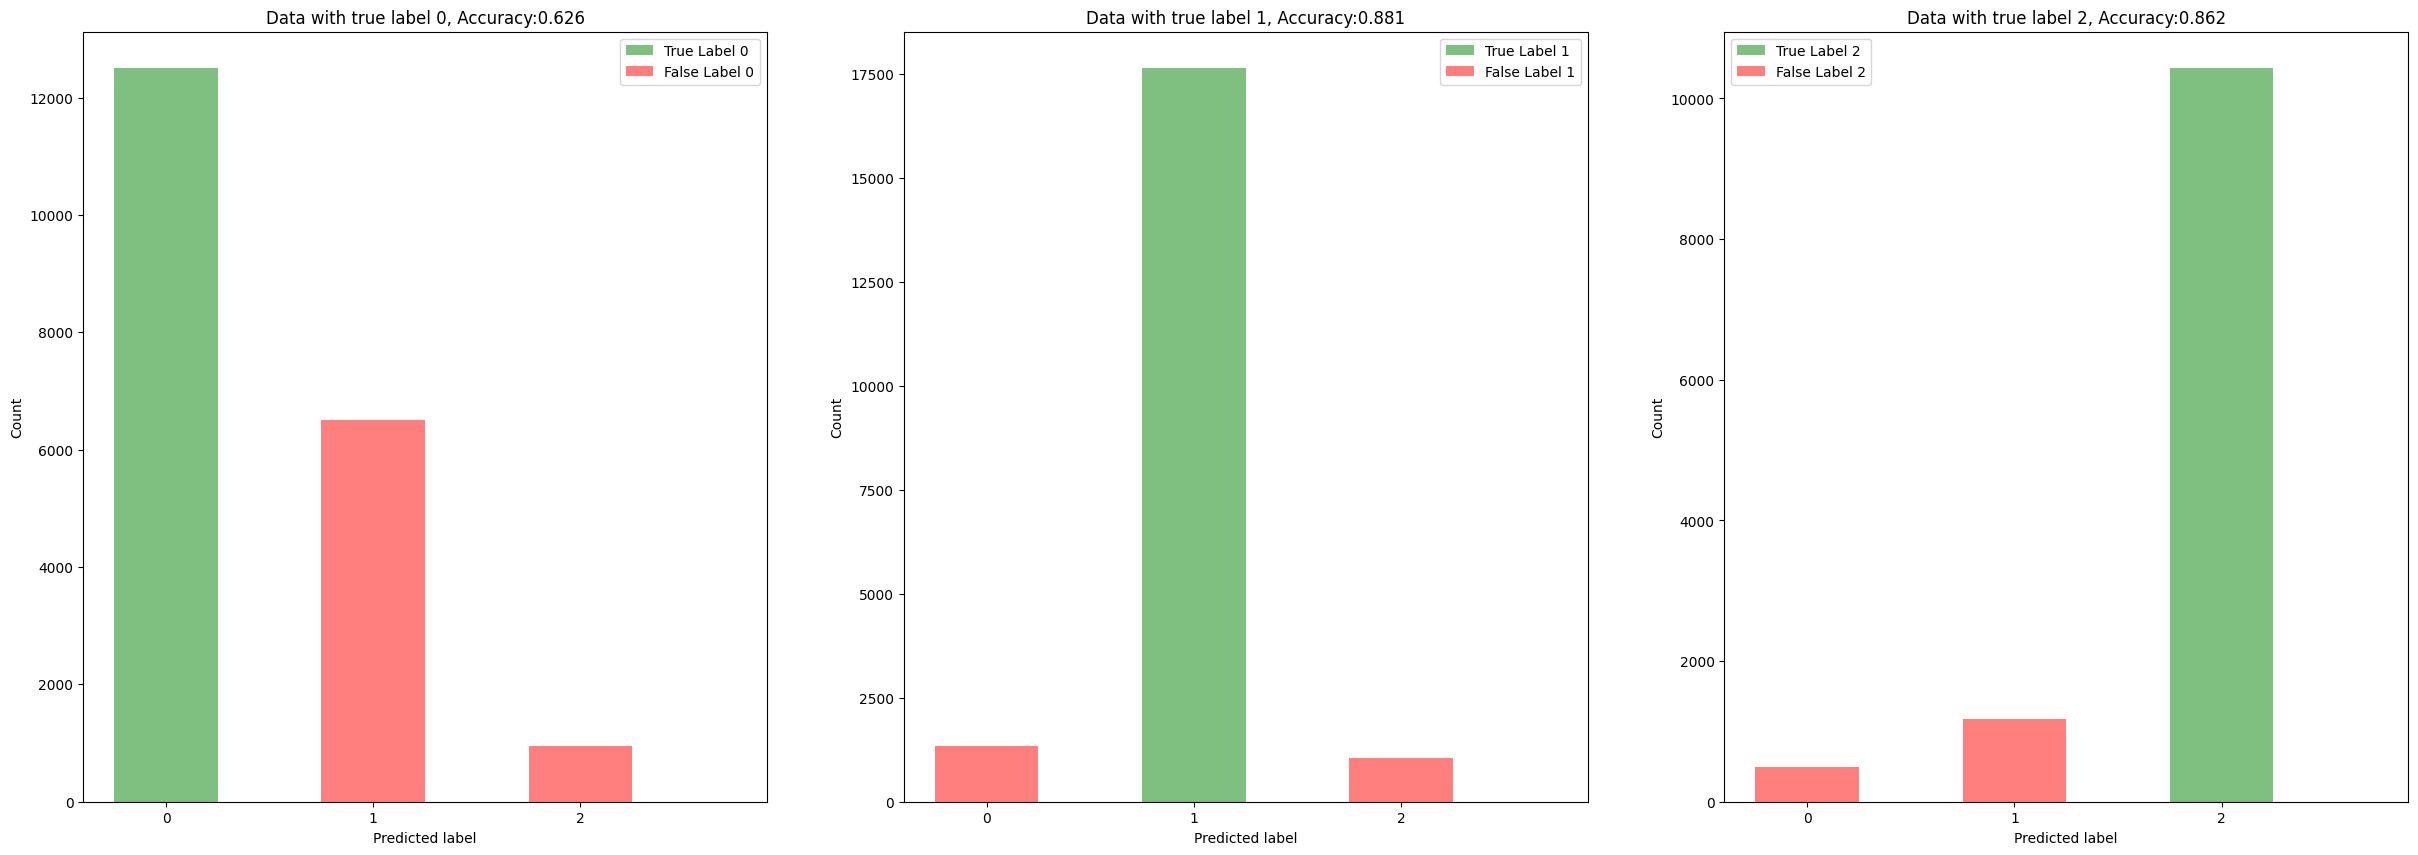

In [19]:
bins = [-0.25, 0.75, 1.75, 2.75] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_val[y_val==label]
    pred_label = y_pred[y_val==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label ' + str(label), align = 'mid', width = 0.5, color = 'green')
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label ' + str(label), align = 'mid', width = 0.5, color = 'red')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f'Data with true label {i}, Accuracy:{accuracy_score(test_label, pred_label):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count')
    ax[i].legend()
    ax[i].set_xticks(range(3))

#plt.legend()
#plt.xlim(-0.5, 2.5)
#plt.xticks(range(3)) 

In [22]:
y_pred =  xgb_model.predict(X_val)
y_pred_train = xgb_model.predict(X_train)

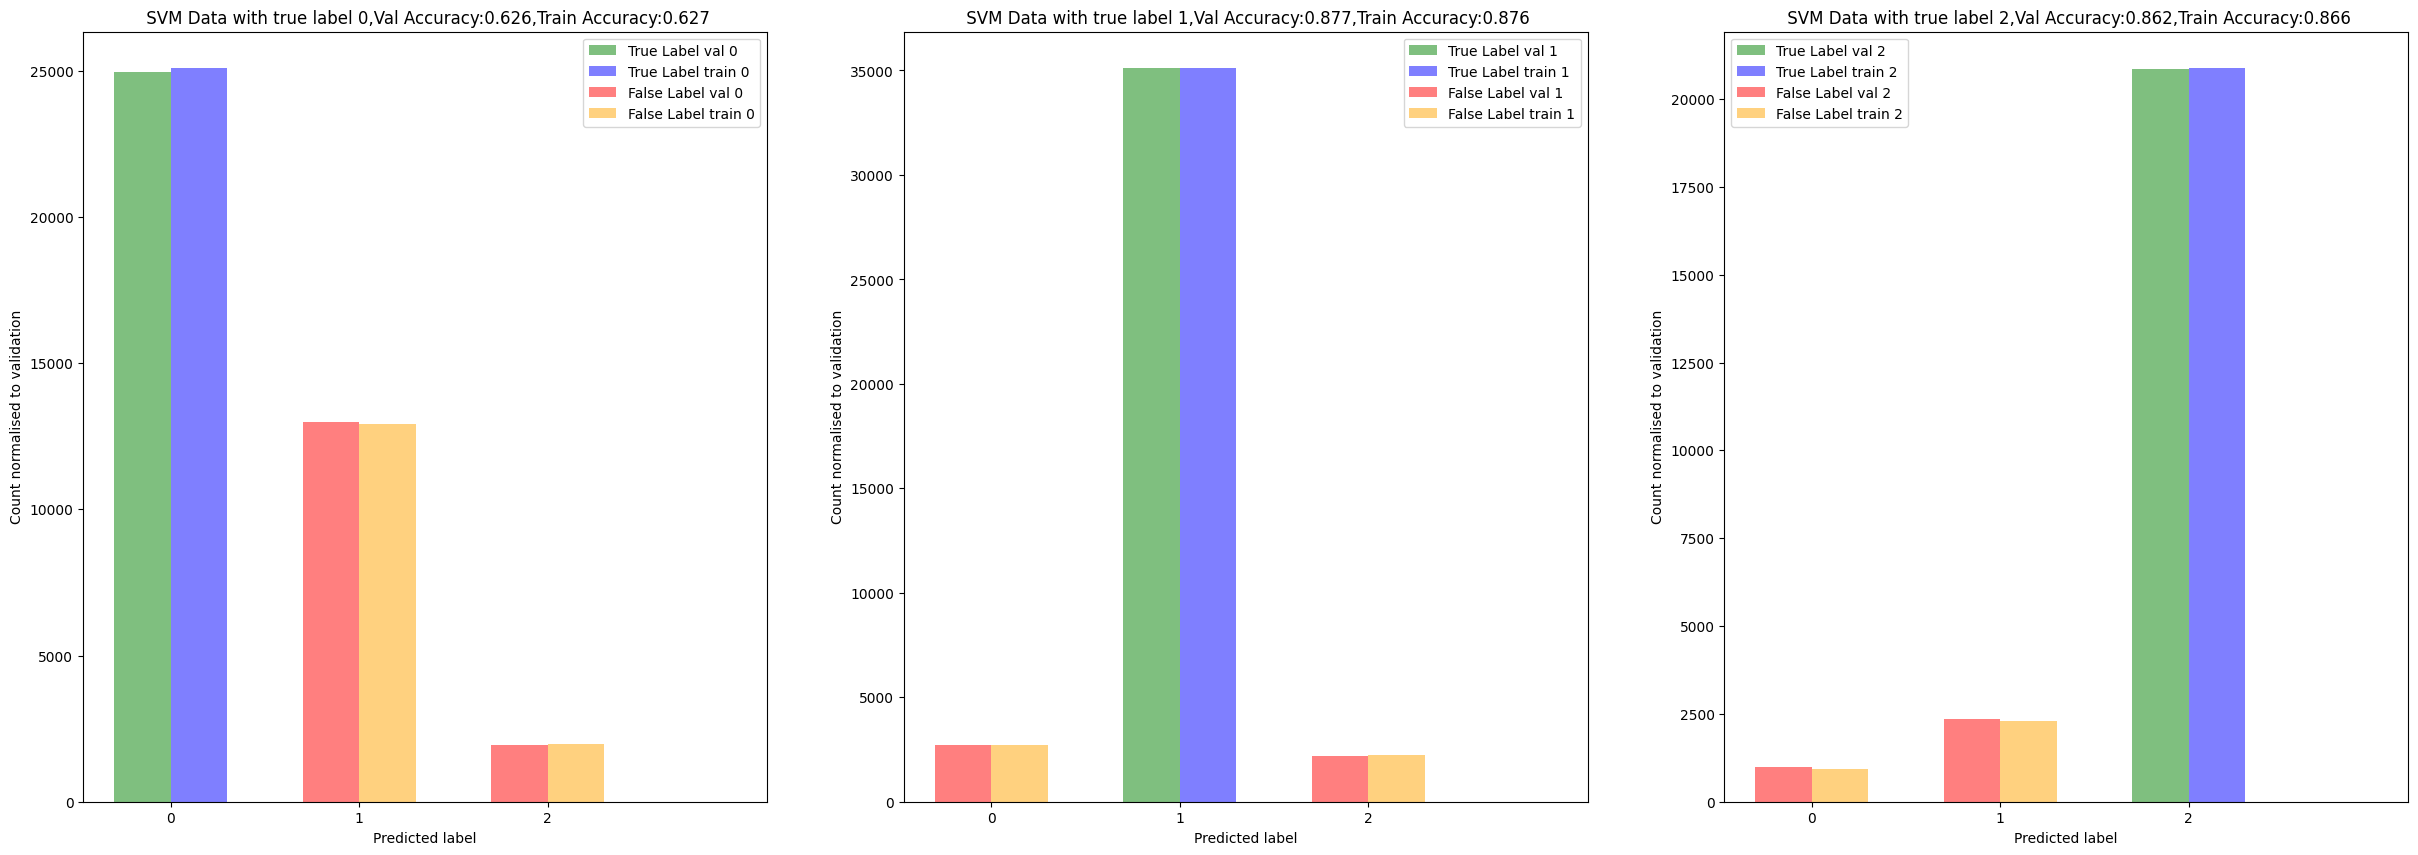

In [23]:
bins = [-0.3, 0.7, 1.7, 2.7] 
bins2 = [0, 1, 2, 3] 
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i, label in enumerate(range(3)):
    test_label = y_val[y_val==label]
    pred_label = y_pred[y_val==label]
    true_label = pred_label[pred_label == test_label]
    false_label= pred_label[pred_label != test_label]
    
    test_label_t = y_train[y_train==label]
    pred_label_t = y_pred_train[y_train==label]
    true_label_t = pred_label_t[pred_label_t == test_label_t]
    false_label_t= pred_label_t[pred_label_t != test_label_t]
    #print(len(false_label))
    ax[i].hist(true_label , bins = bins, histtype = 'barstacked', alpha=0.5, label='True Label val ' + str(label), align = 'mid', width = 0.3, color = 'green')
    ax[i].hist(true_label_t[0:int(round(len(true_label_t)/3,0))] , bins = bins2, histtype = 'barstacked', alpha=0.5, label='True Label train ' + str(label), align = 'mid', width = 0.3, color = 'blue') 
    ax[i].hist(false_label, bins = bins, histtype = 'barstacked', alpha=0.5, label='False Label val ' + str(label), align = 'mid', width = 0.3, color = 'red')
    ax[i].hist(false_label_t[0:int(round(len(false_label_t)/3,0))], bins = bins2, histtype = 'barstacked', alpha=0.5, label='False Label train ' + str(label), align = 'mid', width = 0.3, color = 'orange')
    #ax[i] = plt.xlabel('label')
    ax[i].set_title(f' SVM Data with true label {i},Val Accuracy:{accuracy_score(test_label, pred_label):.3f},Train Accuracy:{accuracy_score(test_label_t, pred_label_t):.3f}')
    ax[i].set_xlabel(xlabel = f'Predicted label')
    ax[i].set_ylabel('Count normalised to validation')
    ax[i].legend()
    ax[i].set_xticks(range(3))